=== ALL summary
count    176.000000
mean      44.866180
std        5.656182
min       34.727297
25%       39.975925
50%       43.591536
75%       50.000000
max       55.000000
Name: qv_value, dtype: float64
=== Var-QV summary
count    88.000000
mean     49.602273
std       3.631091
min      41.000000
25%      47.000000
50%      50.000000
75%      53.000000
max      55.000000
Name: qv_value, dtype: float64
=== Var-QV HiFi
count    28.000000
mean     53.750000
std       1.004619
min      52.000000
25%      53.000000
50%      54.000000
75%      54.250000
max      55.000000
Name: qv_value, dtype: float64
=== Var-QV CLR
count    60.000000
mean     47.666667
std       2.646819
min      41.000000
25%      46.000000
50%      48.000000
75%      50.000000
max      52.000000
Name: qv_value, dtype: float64
=== Mrq-QV summary
count    88.000000
mean     40.130087
std       2.406429
min      34.727297
25%      38.208991
50%      39.942286
75%      42.551691
max      44.035509
Name: qv_value, dtype: 

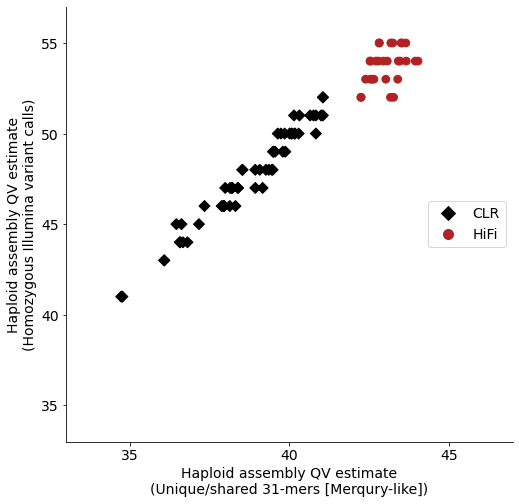

In [29]:
import os
import collections as col
import importlib
import operator
import math

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines

plot_aux_module = '/home/local/work/code/github/project-diploid-assembly/notebooks/aux_mods/plot_aux.py'
plot_aux_spec = importlib.util.spec_from_file_location("plot_aux", plot_aux_module)
plot_aux = importlib.util.module_from_spec(plot_aux_spec)
plot_aux_spec.loader.exec_module(plot_aux)

samples = plot_aux.load_sample_table()
hexcodes, rgbcodes, popmap = plot_aux.load_population_annotation()

prop = plot_aux.get_plot_property

save_plots = False
print_stats = True

# red_black
color_version = 'red_black'

pipeline_version = 'v12'

stats_path = '/home/local/work/data/hgsvc/figSX_panels/qv_estimates'
out_path = os.path.join(stats_path, pipeline_version, 'figSX_panel_qv-estimates')
cache_file = os.path.join(stats_path, 'cache_{}.h5'.format(pipeline_version))


def prob_base_correct(kmer_shared, kmer_total, kmer_size=31):
    
    return (kmer_shared / kmer_total) ** (1/kmer_size)


def base_error_rate(kmer_assembly_only, kmer_total, kmer_size=31):
       
    return 1 - (1 - kmer_assembly_only / kmer_total) ** (1/kmer_size)


def qv_estimate(error_rate):
    
    return -10 * math.log10(error_rate)


def load_qv_estimates(file_path):
    sample_stats = dict()
    with open(file_path, 'r') as table:
        for line in table:
            key, value = line.strip().split()
            if key.endswith('pct'):
                sample_stats[key] = float(value)
            else:
                sample_stats[key] = int(value)
    return sample_stats


def extract_assembly_type(file_name):
    assmt = None
    if '_nhr-' in file_name:
        assmt = 'NHR', 0
    elif 'h1-un' in file_name:
        assmt = 'HAP', 1
    elif 'h2-un' in file_name:
        assmt = 'HAP', 2
    else:
        raise ValueError('ASSMT: {}'.format(file_name))
    if assmt is None:
        raise ValueError('ASSMT: {}'.format(file_name))
    return assmt


if not os.path.isfile(cache_file):
    stat_files = plot_aux.load_plot_data_files(
        stats_path,
        '.qv.tsv',
        pipeline_version)
    plot_data = [load_qv_estimates(fp) for fp in stat_files]

    sample_platform = [
        plot_aux.extract_sample_platform(
            os.path.basename(f),
            mapped_readset=True
        ) for f in stat_files
    ]
    
    haplotypes = [
        extract_assembly_type(
            os.path.basename(f),
        ) for f in stat_files
    ]

    row_index = []
    for (sample, platform), (_, hap) in zip(sample_platform, haplotypes):
        super_pop = samples[sample]['super_population']
        pop = samples[sample]['population']
        row_index.append((sample, super_pop, pop, platform, 'HAP', hap))

    df = pd.DataFrame(
        plot_data,
        columns=sorted(plot_data[0].keys()),
        index=row_index
    )

    df.index = pd.MultiIndex.from_tuples(
        df.index.values,
        names=['sample', 'super_pop', 'pop', 'platform', 'assembly', 'hap']
    )
    df.to_hdf(cache_file, key='cache', mode='w', format='fixed')
    
df = pd.read_hdf(cache_file, 'cache')
df.sort_index(axis=0, inplace=True, level=['sample', 'super_pop', 'pop', 'platform', 'assembly', 'hap'])

kmer_cache = '/home/local/work/data/hgsvc/fig1_panels/kmer_stats/cache_{}.h5'.format(pipeline_version)
if not os.path.isfile(kmer_cache):
    raise ValueError('Need k-mer cache for Merqury-style QV estimate')

kmer_data = pd.read_hdf(kmer_cache, 'cache')
kmer_data.sort_index(axis=0, inplace=True, level=['sample', 'super_pop', 'pop', 'platform', 'assembly', 'hap'])
    
errors, missing = plot_aux.check_cache_consistency(df)
if errors:
    raise ValueErrors('Skip sample(s) in cache: {}'.format(errors))
if missing:
    print(sorted(missing))
    print('---------------')
    
    
def plot_kmer_stats(sample_stats, kmer_stats):
    
    fig, axis = plt.subplots(figsize=(8,8))
    
    qv_collect = col.defaultdict(list)
    kmer_collect = col.defaultdict(list)
    
    for platform in plot_aux.get_sequencing_platforms():
        for hap in [1, 2]:
            subset = sample_stats.xs((platform, hap) , level=('platform', 'hap'), drop_level=False)
            get_assembly_kmers = operator.itemgetter(
                *(
                    'Hap{}_only'.format(hap),
                    'Hap_only'
                )
            )
            get_remaining_kmers = operator.itemgetter(
                *(
                    'Illumina_only',
                    'Hap{}_Illumina'.format(hap),
                    'Hap_Illumina',
                    'Hap{}_GRCh38'.format(hap),
                    'Hap_GRCh38',
                    'GRCh38_Illumina',
                    'GRCh38_shared'
                )
            )
            
            x_values = []
            y_values = []
            colors = []
            labels = []
            
            for idx, row in subset.iterrows():
                variant_qv = row['QV_all_hom_highconf|unlifted']
                
                kmer_idx = idx[0], idx[1], idx[2], idx[3], idx[4], 0
                kmer_data = kmer_stats.loc[kmer_idx, :]
                assert kmer_data.shape == (13,), 'Ambig. kmer stats: {}'.format(kmer_data)
                
                kmer_assm_count = sum(get_assembly_kmers(kmer_data))
                
                remaining_kmers = get_remaining_kmers(kmer_data)
                hap_single_kmers = remaining_kmers[1]
                hap_both_kmers = remaining_kmers[2]
                
                kmer_collect[(idx[0], idx[1], platform, hap)].append(hap_single_kmers)
                if hap == 1:
                    kmer_collect[(idx[0], idx[1], platform, 0)].append(hap_both_kmers)
                
                kmer_remain_count = sum(remaining_kmers)
                kmer_total_count = kmer_assm_count + kmer_remain_count
                error_rate = base_error_rate(kmer_assm_count, kmer_total_count, kmer_size=31)
                merqury_qv = qv_estimate(error_rate)
                
                label = idx[0] + '-{}-Hap{}'.format(platform, hap)
                qv_collect[(idx[0], idx[1], platform, 'mrq_qv', hap)].append(merqury_qv)
                qv_collect[(idx[0], idx[1], platform, 'var_qv', hap)].append(variant_qv)
                                
                x_values.append(merqury_qv)
                y_values.append(variant_qv)
                if color_version == 'full':
                    colors.append(rgbcodes[idx[2]])
                elif color_version == 'red_black':
                    colors.append(plot_aux.get_platform_color(platform))
                else:
                    raise ValueError()
                labels.append(label)
            
            axis.scatter(
                x_values,
                y_values,
                s=prop('plot_marker_size'),
                c=colors,
                marker=prop('{}_marker'.format(platform)),
                label=labels
            )

    axis.set_xlabel(
        'Haploid assembly QV estimate\n(Unique/shared 31-mers [Merqury-like])',
        fontsize=prop('fontsize_legend')
    )
    axis.set_ylabel(
        'Haploid assembly QV estimate\n(Homozygous Illumina variant calls)',
        fontsize=prop('fontsize_legend')
    )
    
    axis.tick_params(
        axis='both',
        which='major',
        labelsize=prop('fontsize_axis_ticks')
    )
    
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    
    # build custom legend
    custom_lines = [
        lines.Line2D(
            [0], [0],
            color='black' if color_version == 'full' else plot_aux.get_platform_color('CLR'),
            markersize=prop('legend_marker_size'),
            marker=prop('CLR_marker'),
            ls='None',
            label='CLR'
        ),
        lines.Line2D(
            [0], [0],
            color='black' if color_version == 'full' else plot_aux.get_platform_color('HiFi'),
            markersize=prop('legend_marker_size'),
            marker=prop('HiFi_marker'),
            ls='None',
            label='HiFi'
        )   
    ]
    
    axis.legend(
        handles=custom_lines,
        loc='center right',
        prop={'size': prop('fontsize_legend')}
    )

    if missing:
        plot_aux.add_incomplete_stamp(axis, 0.2, 0.6)
        
    x_ticks = list(range(35, 50, 5))
    y_ticks = list(range(35, 60, 5))
    
    axis.set_xticks(x_ticks)
    axis.set_yticks(y_ticks)
    
    #  hlines(self, y, xmin, xmax, colors=None, linestyles='solid', label='', *, data=None, **kwargs)[source]
#     axis.hlines(
#         [40, 45, 50, 55],
#         33,
#         [46, 46, 46, 46],
#         colors='grey',
#         linestyles='dashed',
#         zorder=0,
#         alpha=0.5
#     )
    
#     axis.vlines(
#         [35, 40, 45, 50],
#         37,
#         [57, 57, 57, 57],
#         colors='grey',
#         linestyles='dashed',
#         zorder=0,
#         alpha=0.5
#     )
    
    axis.set_xlim(33, 47)
    axis.set_ylim(33, 57)
    
    extra_artists = []

    return fig, extra_artists, qv_collect, kmer_collect
        
fig, exart, qv_collect, kmer_collect = plot_kmer_stats(df, kmer_data)

if save_plots:
    fig.savefig(
        out_path + '_lowres.png',
        dpi=prop('dpi_low_res'),
        bbox_inches='tight',
        extra_artists=exart
    )
    fig.savefig(
        out_path + '.png',
        dpi=prop('dpi_high_res'),
        bbox_inches='tight',
        extra_artists=exart
    )
    fig.savefig(out_path + '.svg', bbox_inches='tight', extra_artists=exart)

if print_stats:
    rows = sorted(qv_collect.keys())
    qv_values = [qv_collect[r] for r in rows]
    row_index = pd.MultiIndex.from_tuples(
        rows,
        names=['sample', 'super_pop', 'platform', 'qv_type', 'hap']
    )
    qv_stats = pd.DataFrame(qv_values, index=row_index)
    qv_stats.columns = ['qv_value']
    print('=== ALL summary')
    print(qv_stats['qv_value'].describe())
    print('=== Var-QV summary')
    sub = qv_stats.xs('var_qv', level='qv_type')
    print(sub['qv_value'].describe())
    print('=== Var-QV HiFi')
    sub_hifi = sub.xs('HiFi', level='platform')
    print(sub_hifi['qv_value'].describe())
    print('=== Var-QV CLR')
    sub_clr = sub.xs('CLR', level='platform')
    print(sub_clr['qv_value'].describe())
    print('==========================')
    print('=== Mrq-QV summary')
    sub = qv_stats.xs('mrq_qv', level='qv_type')
    print(sub['qv_value'].describe())
    print('=== Mrq-QV HiFi')
    sub_hifi = sub.xs('HiFi', level='platform')
    print(sub_hifi['qv_value'].describe())
    print('=== Mrq-QV CLR')
    sub_clr = sub.xs('CLR', level='platform')
    print(sub_clr['qv_value'].describe())
    
    print('======== K-mer stats ============')
    rows = sorted(kmer_collect.keys())
    kmer_counts = [kmer_collect[r] for r in rows]
    row_index = pd.MultiIndex.from_tuples(
        rows,
        names=['sample', 'super_pop', 'platform', 'hap']
    )
    kmer_counts = pd.DataFrame(kmer_counts, index=row_index)
    kmer_counts.columns = ['kmer_count']
    kmer_counts['mega_kmer_count'] = (kmer_counts['kmer_count'] / 1e6).round(2)
    print('=== kmer summary')
    hom = kmer_counts.xs(0, level='hap', drop_level=False)
    het = kmer_counts.loc[~kmer_counts.index.isin(hom.index), :]
    print('=== hom')
    print(hom['mega_kmer_count'].describe())
    print('=== het')
    print(het['mega_kmer_count'].describe())
    
    print('=== hom summary')
    hom_clr = hom.xs('CLR', level='platform')
    hom_hifi = hom.xs('HiFi', level='platform')
    hom_afr = hom.xs('AFR', level='super_pop', drop_level=False)
    hom_other = hom.loc[~hom.index.isin(hom_afr.index), :]
    print('CLR ', hom_clr['mega_kmer_count'].describe())
    print('HiFi ', hom_hifi['mega_kmer_count'].describe())
    print('AFR ', hom_afr['mega_kmer_count'].describe())
    print('non-AFR ', hom_other['mega_kmer_count'].describe())
    
    print('=== het summary')
    het_clr = het.xs('CLR', level='platform')
    het_hifi = het.xs('HiFi', level='platform')
    het_afr = het.xs('AFR', level='super_pop', drop_level=False)
    het_other = het.loc[~het.index.isin(het_afr.index), :]
    print('CLR ', het_clr['mega_kmer_count'].describe())
    print('HiFi ', het_hifi['mega_kmer_count'].describe())
    print('AFR ', het_afr['mega_kmer_count'].describe())
    print('non-AFR ', het_other['mega_kmer_count'].describe())

